# Baseline results: Normalizing Flow with Glow Blocks

As a baseline, we have a NF model without causal understanding. That is, we do not impose a prior distribution that adheres to the causal model implied by the latent causal graph. In addition, we do not maximize the likelihood across the different distributions, but treat the entire dataset as a single distribution.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import normflows as nf
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets.utils as dataset_utils
from PIL import Image
from pl_bolts.models.autoencoders.components import resnet18_decoder, resnet18_encoder
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

from gendis.datasets import CausalMNIST, ClusteredMultiDistrDataModule
from gendis.model import NeuralClusteredASCMFlow
from gendis.noncausal.flows import (
    CouplingLayer,
    Dequantization,
    GatedConvNet,
    Reshape,
    SplitFlow,
    SqueezeFlow,
    VariationalDequantization,
    create_channel_mask,
    create_checkerboard_mask,
)
from gendis.noncausal.model import ImageFlow
from gendis.variational.vae import VAE

/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/Users/adam2392/miniforge3/envs/cdrl/lib/python3.

In [3]:
def show_imgs(imgs, title=None, row_size=4):
    # Form a grid of pictures (we use max. 8 columns)
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    is_int = (
        imgs.dtype == torch.int32
        if isinstance(imgs, torch.Tensor)
        else imgs[0].dtype == torch.int32
    )
    nrow = min(num_imgs, row_size)
    ncol = int(math.ceil(num_imgs / nrow))
    imgs = torchvision.utils.make_grid(
        imgs, nrow=nrow, pad_value=128 if is_int else 0.5
    )
    np_imgs = imgs.cpu().numpy()
    # Plot the grid
    plt.figure(figsize=(1.5 * nrow, 1.5 * ncol))
    plt.imshow(np.transpose(np_imgs, (1, 2, 0)), interpolation="nearest")
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()

In [10]:
seed = 6
graph_type = "chain"
epoch = 656
step = 91980
results_dir = Path(
    f"/Users/adam2392/pytorch_data/data/noncausalflow/nf-vardeq-actnorm-3point1M-cosinelr-batch256-{graph_type}-seed={seed}/"
)


# multi-scale w/ 256 batch size
seed = 5
epoch = 730
step = 102340
results_dir = Path(
    f"/Users/adam2392/pytorch_data/data/noncausalflow/nf-actnorm-3point1M-cosinelr-batch256-{graph_type}-seed={seed}/"
)

checkpoint_fname = results_dir / f"epoch={epoch}-step={step}.ckpt"
model = ImageFlow.load_from_checkpoint(checkpoint_fname)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


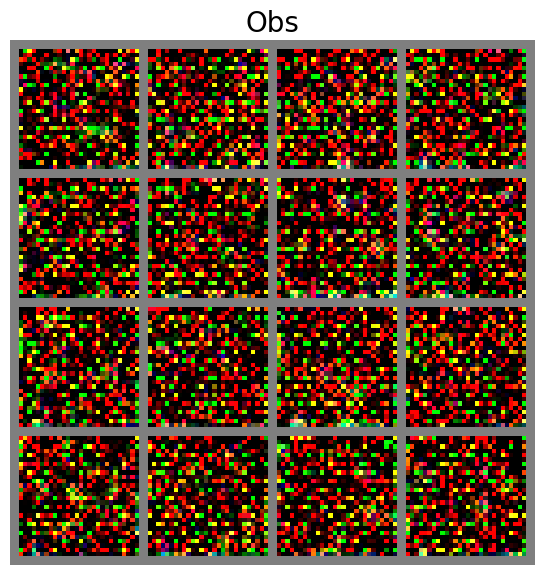

In [11]:
obs_imgs = model.sample(img_shape=[16, 12, 7, 7])
new_obs_imgs = torch.zeros_like(obs_imgs)
for idx, whole_image in enumerate(obs_imgs):
    for color_idx in range(3):
        # print(image.min(), image.max())
        image = whole_image[color_idx, ...]
        new_image = (image - image.min()) / (image.max() - image.min())
        new_obs_imgs[idx, color_idx, ...] = new_image
show_imgs(obs_imgs, title="Obs")

In [36]:
img_scale_shape = (5, 24, 7, 7)
prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
output = prior.sample(img_scale_shape)
ldj = torch.zeros(img_scale_shape[0])
for flow in reversed(model.flows):
    output, ldj = flow(output, ldj, reverse=True)
    print("Running: ", type(flow), output.shape)

Running:  <class 'gendis.noncausal.flows.Reshape'> torch.Size([5, 24, 7, 7])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([5, 24, 7, 7])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([5, 24, 7, 7])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([5, 24, 7, 7])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([5, 24, 7, 7])
Running:  <class 'gendis.noncausal.flows.SqueezeFlow'> torch.Size([5, 6, 14, 14])
Running:  <class 'gendis.noncausal.flows.SplitFlow'> torch.Size([5, 12, 14, 14])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([5, 12, 14, 14])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([5, 12, 14, 14])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([5, 12, 14, 14])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([5, 12, 14, 14])
Running:  <class 'gendis.noncausal.flows.SqueezeFlow'> torch.Size([5, 3, 28, 28])
Runnin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


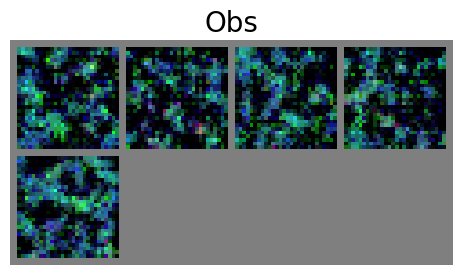

In [37]:
show_imgs(output, title="Obs")

<Axes: ylabel='Count'>

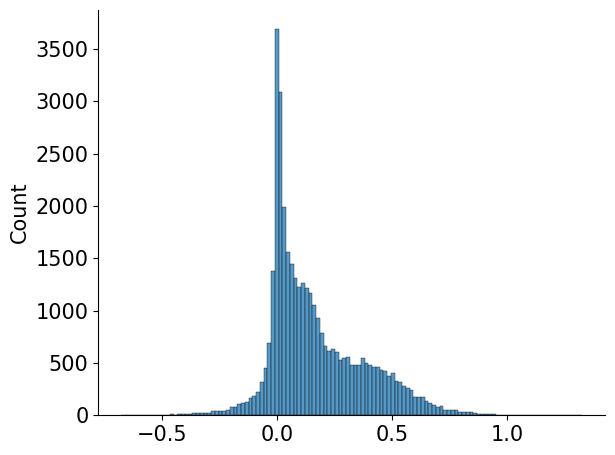

In [38]:
sns.histplot(obs_imgs.flatten())

# Normal MNIST Multi-scale NF model

In [6]:
seed = 1
graph_type = "chain"
epoch = 235
step = 50740

epoch = 2283
step = 491060

results_dir = Path(
    f"/Users/adam2392/pytorch_data/data/noncausalflow/nf-vardeq-discretize-normalMNIST-batch256-{graph_type}-seed={seed}/"
)

# XXX: bad since no discreteizing and/or dequant?
# seed = 3
# epoch = 6124
# step = 1316875
# results_dir = Path(
#     f"/Users/adam2392/pytorch_data/data/noncausalflow/nf-nf-normalMNIST-batch256-{graph_type}-seed={seed}/"
# )

checkpoint_fname = results_dir / f"epoch={epoch}-step={step}.ckpt"
model = ImageFlow.load_from_checkpoint(checkpoint_fname)

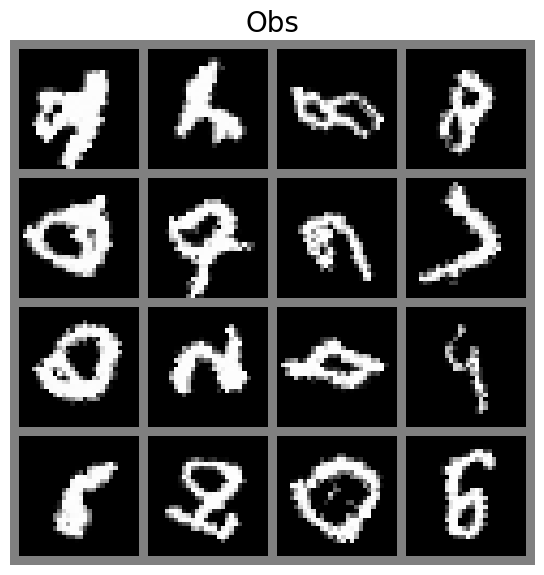

In [7]:
n_chs = 1
obs_imgs = model.sample(img_shape=[16, 4, 7, 7])
# obs_imgs = obs_imgs / obs_imgs.max()
# new_obs_imgs = torch.zeros_like(obs_imgs)
# for idx, whole_image in enumerate(obs_imgs):
#     for color_idx in range(n_chs):
#         # print(image.min(), image.max())
#         image = whole_image[color_idx, ...]
#         new_image = (image - image.min()) / (image.max() - image.min())
#         new_obs_imgs[idx, color_idx, ...] = new_image
show_imgs(obs_imgs, title="Obs")